In [130]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread
from csbdeep.utils import plot_some
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.data import RawData, create_patches_reduced_target

In [131]:
limit_gpu_memory(fraction=1/2)

input  image size = (2, 256, 256)
output image size = (256, 256)


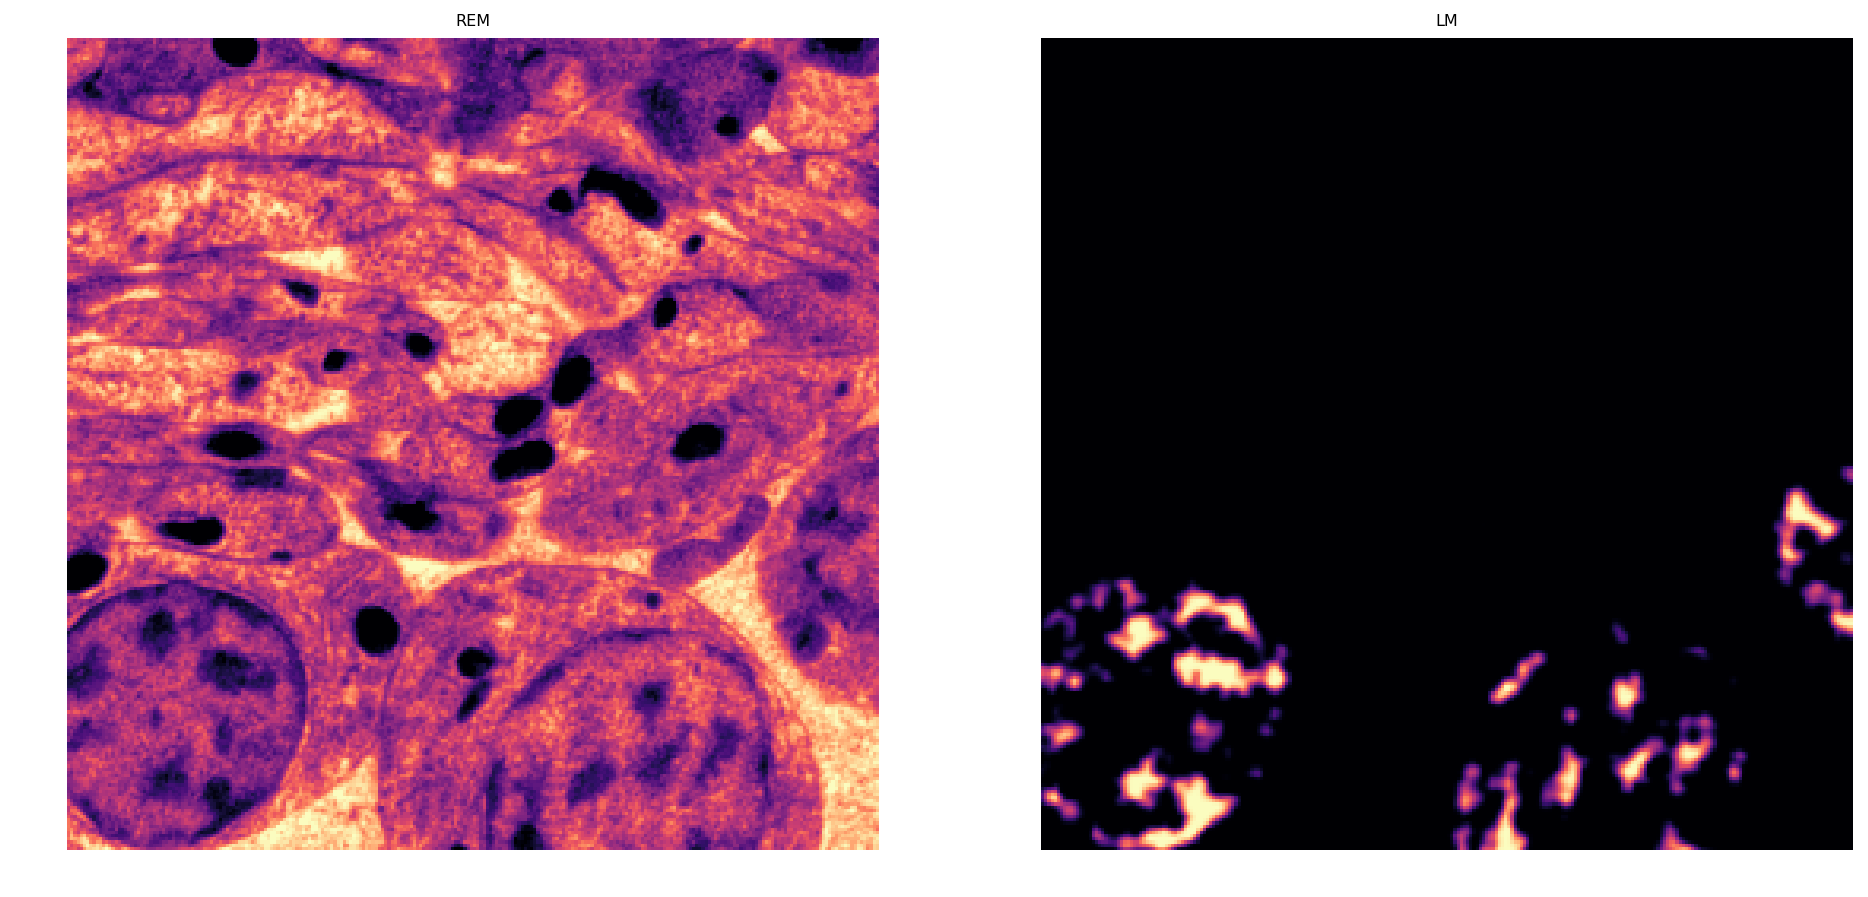

In [132]:
y = imread('/home/s353960/programs/CSBDeep/Fluo_tif_16/S3.tif')
x = imread('/home/s353960/programs/CSBDeep/Rem_tif_stack/S3.tif')
print('input  image size =', x.shape)
print('output image size =', y.shape)
plt.figure(figsize=(16,10))
plot_some(np.stack([x,np.broadcast_to(y,x.shape)]),
          title_list=[['REM','LM']], 
          pmin=2,pmax=99.8);

In [133]:
raw_data = RawData.from_folder (
    basepath    = '/home/s353960/programs/CSBDeep',
    source_dirs = ['Rem_tif_stack'],
    target_dir  = 'Fluo_tif_16',
    axes        = 'ZYX',
)

In [134]:
X, Y, XY_axes = create_patches_reduced_target (
    raw_data            = raw_data,
    patch_size          = (None,128,128),
    n_patches_per_image = 16,
    target_axes         = 'YX',
    reduction_axes      = 'Z',
    save_file           = '/home/s353960/programs/CSBDeep/V6/my_training_data.npz',
)

   10 raw images x    1 transformations   =    10 images
   10 images     x   16 patches per image =   160 patches in total
Input data:
/home/s353960/programs/CSBDeep: target='Fluo_tif_16', sources=['Rem_tif_stack'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Broadcast target image to the shape of source
Patch size:
2 x 128 x 128















  0%|          | 0/10 [00:00<?, ?it/s]












 80%|████████  | 8/10 [00:00<00:00, 73.42it/s]












100%|██████████| 10/10 [00:00<00:00, 72.01it/s]

Saving data to /home/s353960/programs/CSBDeep/V6/my_training_data.npz.


In [135]:
print("shape of X   =", X.shape)
print("shape of Y   =", Y.shape)
print("axes  of X,Y =", XY_axes)

shape of X   = (160, 1, 2, 128, 128)
shape of Y   = (160, 1, 1, 128, 128)
axes  of X,Y = SCZYX


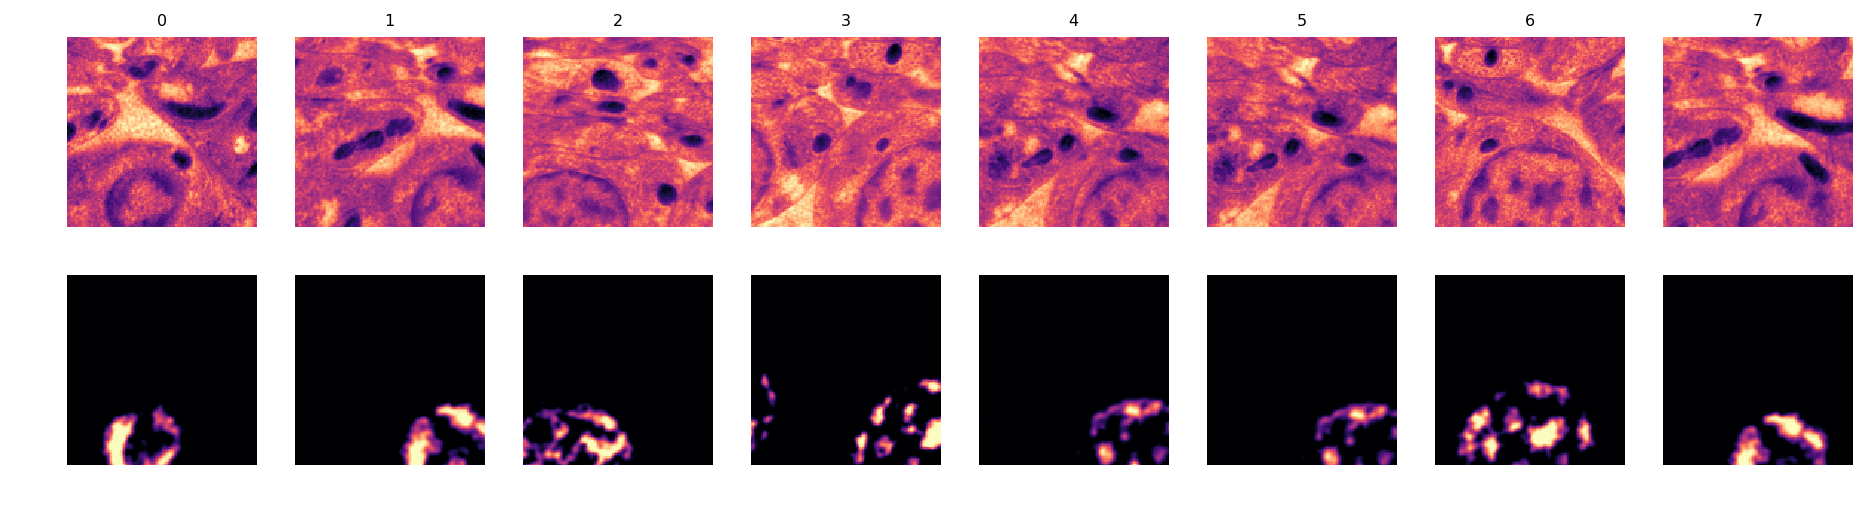

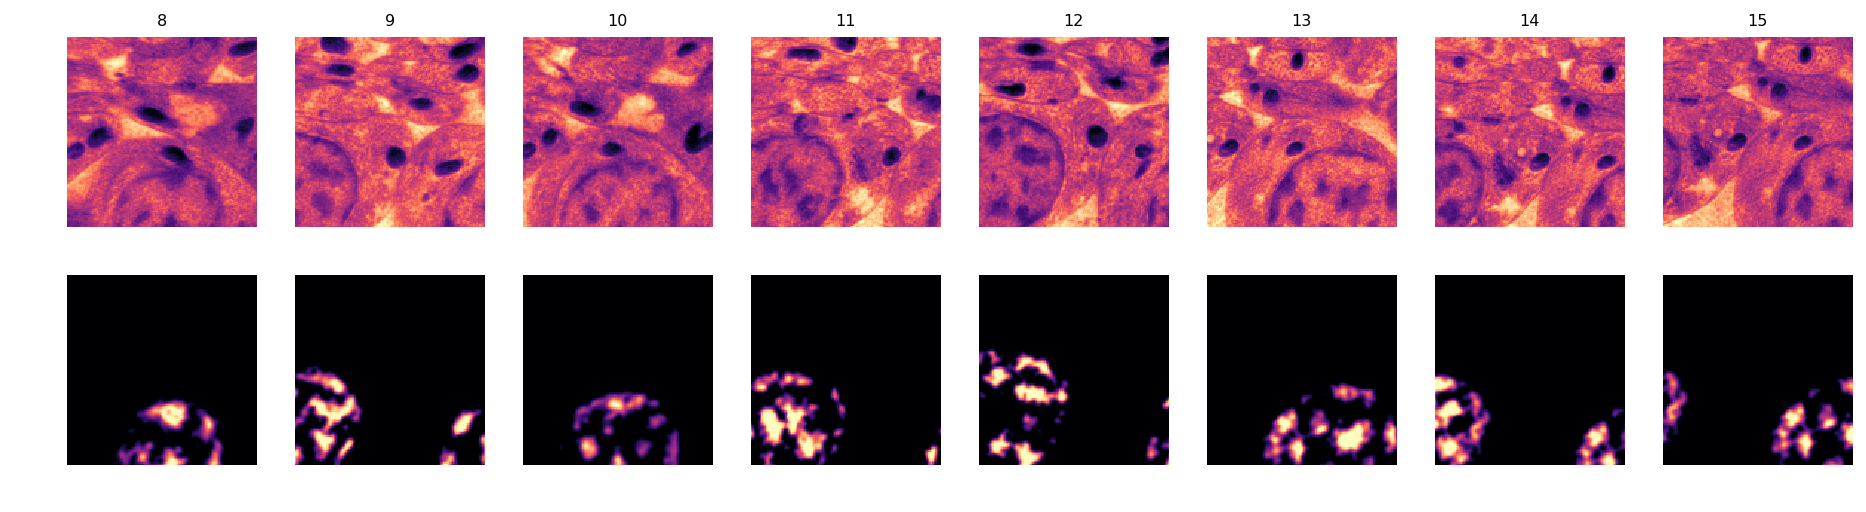

In [136]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;